## Name: Jose Aries E. De Los Santos
## DS397 Machine Problem 2 2b

# PROBLEM 2: Fisher Iris Flower Data Classification

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mpl_toolkits.mplot3d as Axes3D
from matplotlib import cm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

##  **Load Dataset**

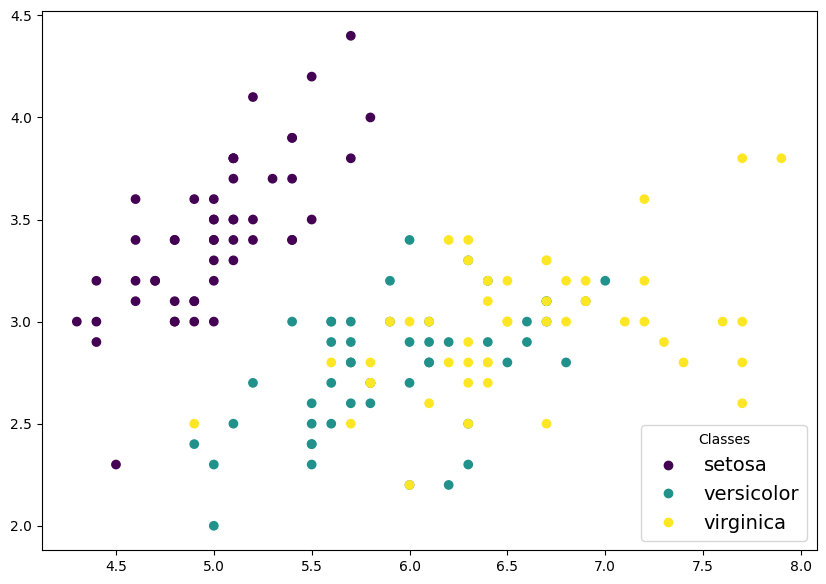

In [ ]:
from sklearn.datasets import load_iris
from sklearn import datasets

iris = datasets.load_iris()
# iris = load_iris(as_frame=True)

# _, ax = plt.subplots()
# scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
# ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
# _ = ax.legend(
#     scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
# )

fig, ax = plt.subplots(figsize=(10,7))
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.legend(scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes",fontsize=14)
plt.show()

## Extract the Features and Target

In [ ]:
# Create a DataFrame from the features and target
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target  # Add target variable to DataFrame

X = iris_df.iloc[:,[0,2]].to_numpy()
y = iris.target
# iris_df[['sepal length (cm)', 'petal length (cm)', 'target']].head()
iris_df.iloc[:,[0,2]]

,sepal length (cm),petal length (cm)
0,5.1,1.4
1,4.9,1.4
2,4.7,1.3
3,4.6,1.5
4,5.0,1.4
...,...,...
145,6.7,5.2
146,6.3,5.0
147,6.5,5.2
148,6.2,5.4


## Split the data

Using the train_test_split function, split the data into 70% training and 30% testing, with stratification on the species

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

##Checking the dimensions
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(105, 2)
(105,)
(45, 2)
(45,)


## Normalize the data using Standard Scaling

In [ ]:
## For this we only need to normalized the features data
scalerX = StandardScaler()
X_train_scaled = scalerX.fit_transform(X_train)
X_test_scaled = scalerX.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(X_train_scaled.shape == X_train.shape)
print(X_test_scaled.shape == X_test.shape)

(105, 2)
(45, 2)
True
True


## Preparation of Datasets for One-vs-One Scheme

In [ ]:
#0v1 scheme
X1_train,y1_train =  X_train_scaled[(y_train == 0) | (y_train == 1)], y_train[(y_train == 0) | (y_train == 1)]
#1v2 scheme
X2_train,y2_train = X_train_scaled[(y_train == 1) | (y_train == 2)], y_train[(y_train == 1) | (y_train == 2)]
#0v2 scheme
X3_train,y3_train = X_train_scaled[(y_train == 0) | (y_train == 2)], y_train[(y_train == 0) | (y_train == 2)]


# iris_df[iris_df['target'] == 0][['sepal length (cm)', 'petal length (cm)', 'target']].head()
# iris_df[iris_df['target'] == 0][['sepal length (cm)']]

## Colormaps for One versus one Scheme

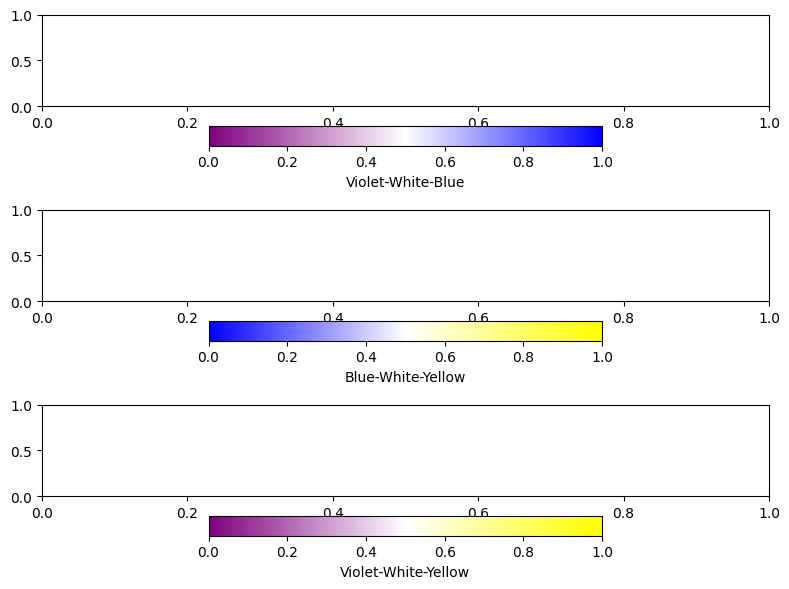

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
# Define the colors for the colormap
colors1 = [(0.5, 0, 0.5), (1, 1, 1), (0, 0, 1)]
colors2 = [(0, 0, 1), (1, 1, 1), (1, 1, 0)]
colors3 = [(0.5, 0, 0.5), (1, 1, 1),(1, 1, 0)]

# Define the positions for the colors
positions = [0, 0.5, 1]

# Create the colormap
vwb_cmap = LinearSegmentedColormap.from_list('violet_white_blue', list(zip(positions, colors1)))
bwy_cmap = LinearSegmentedColormap.from_list('blue_white_yellow', list(zip(positions, colors2)))
vwy_cmap = LinearSegmentedColormap.from_list('violet_white_yellow', list(zip(positions, colors3)))

# Plot a colorbar to visualize the colormap
# Create subplots for colorbars
fig, axs = plt.subplots(3, 1, figsize=(8, 6))

# Plot colorbars for each colormap
for i, cmap, title in zip(range(3), [vwb_cmap, bwy_cmap, vwy_cmap], ['Violet-White-Blue', 'Blue-White-Yellow', 'Violet-White-Yellow']):
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axs[i], orientation='horizontal')
    cbar.set_label(title)

plt.tight_layout()
plt.show()

## **SVM1**

In [ ]:
class SoftMarginSVC1:
    def __init__(self, C=1000, gamma=1):
        self.C = C           # Box constraint
        self.gamma = gamma   # RBF kernel scale
        self.X = None  # Training set X
        self.y = None  # Training set y
        self.b = 0     # Bias

    def kernel_func(self, x1, x2):
        return np.exp(-self.gamma * pairwise_distances(x1, x2, metric='sqeuclidean'))

    def fit(self, X, y):
        self.X, self.y = X, np.where(y == 0,-1,1)   # Map y \in [0,1] into [-1,1]
        n_samples = X.shape[0]

        # Create kernel (Gram) matrix
        self.K = self.kernel_func(self.X, self.X)

        # Define the objective function for the dual problem
        def objective(alpha):
            # Dual objective
            #return 0.5 * np.sum(np.outer(alpha,alpha) * np.outer(self.y,self.y) * self.K) - np.sum(alpha)
            return 0.5 * np.dot(np.dot(alpha * self.y, self.K), alpha * self.y) - np.sum(alpha)

        # Initial guess for alpha
        #initial_alpha = np.random.rand(1,n_samples)
        initial_alpha = np.zeros(n_samples)

        # Define the constraints and bounds
        cons = ({'type': 'eq', 'fun': lambda alpha: np.dot(alpha, self.y)})
        bnds = [(0, self.C) for _ in initial_alpha]

        # Minimize the objective function subject to the constraints
        res = minimize(objective, initial_alpha, constraints=cons,
                       bounds=bnds, method='SLSQP')
        print(res.message)

        # Extract the optimal alpha values
        alpha = res.x

        # Extract support vectors
        self.sv_indices = alpha > 1e-5
        self.support_vectors = self.X[self.sv_indices,:]
        self.support_labels = self.y[self.sv_indices]
        self.alpha = alpha[self.sv_indices]

        # Calculate the bias
        y_pred = self.predict_proba(self.support_vectors)
        self.b = np.mean(self.support_labels - y_pred)

    def predict(self, X):
      return np.where(self.predict_proba(X) > 0, 1, 0)
      # return self.predict_proba(X) > 0

    def predict_proba(self, X):
        K = self.kernel_func(self.support_vectors, X)
        return np.dot(self.support_labels * self.alpha, K) + self.b

    def plot_decision(self, X, y):
      nx, ny = 100, 100
      xv, yv = np.meshgrid(np.linspace(-3,3,nx),
                            np.linspace(-3,3,ny))
      zv = np.zeros(xv.shape)
      for i in range(nx):
          for j in range(ny):
              zv[i,j] = self.predict_proba(np.array([xv[i,j], yv[i,j]]).reshape(1,-1))

      plt.figure(figsize=(10,7))
      # Normalize colors so that 0 will match white
      divnorm = mcolors.TwoSlopeNorm(vmin=np.min(zv), vcenter=0, vmax=np.max(zv))
      con = plt.contourf(xv, yv, zv, cmap=vwb_cmap, levels=50, alpha=0.6, norm=divnorm)

      plt.scatter(X[y == 0,0],X[y == 0,1], s=50, color='#8A2BE2', marker='o',
                  alpha=0.9, edgecolors='k', label='(0) Training samples')
      plt.scatter(X[y == 1,0],X[y == 1,1], s=50, color='blue', marker='o',
                  alpha=0.9, edgecolors='k', label='(1) Training samples')
      plt.scatter(self.support_vectors[:,0],self.support_vectors[:,1], s=150,
                  marker='*', facecolors="None", edgecolors='k',label='Support Vectors')
      plt.colorbar(con)
      plt.legend()
      plt.show()

### Classifier 1 (0v1)

Optimization terminated successfully
Training accuracy: 1.0


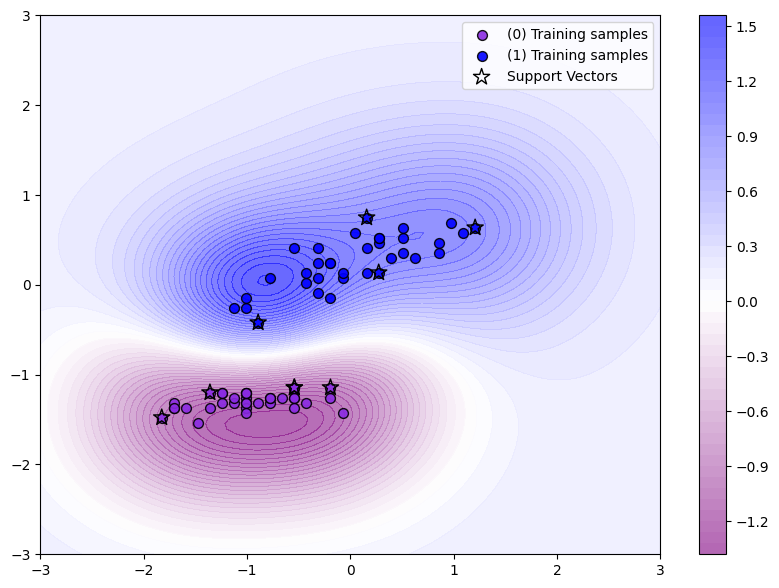

In [ ]:
# Train the soft-margin SVC
svc1 = SoftMarginSVC1(C=3,gamma=0.9)
svc1.fit(X1_train, y1_train)

# Make predictions
y1_train_pred = svc1.predict(X1_train)

# Evaluate accuracy
train_acc = np.mean(y1_train_pred == y1_train)
print("Training accuracy:", train_acc)

svc1.plot_decision(X1_train,y1_train)

## **SVM2**

In [ ]:
class SoftMarginSVC2:
    def __init__(self, C=3000, gamma=0.009):
        self.C = C           # Box constraint
        self.gamma = gamma   # RBF kernel scale
        self.X = None  # Training set X
        self.y = None  # Training set y
        self.b = 0     # Bias

    def kernel_func(self, x1, x2):
        return np.exp(-self.gamma * pairwise_distances(x1, x2, metric='sqeuclidean'))

    def fit(self, X, y):
        self.X, self.y = X, np.where(y == 1,-1,1)  # Map y \in [1,2] into [-1,1]
        n_samples = X.shape[0]

        # Create kernel (Gram) matrix
        self.K = self.kernel_func(self.X, self.X)

        # Define the objective function for the dual problem
        def objective(alpha):
            # Dual objective
            #return 0.5 * np.sum(np.outer(alpha,alpha) * np.outer(self.y,self.y) * self.K) - np.sum(alpha)
            return 0.5 * np.dot(np.dot(alpha * self.y, self.K), alpha * self.y) - np.sum(alpha)

        # Initial guess for alpha
        #initial_alpha = np.random.rand(1,n_samples)
        initial_alpha = np.zeros(n_samples)

        # Define the constraints and bounds
        cons = ({'type': 'eq', 'fun': lambda alpha: np.dot(alpha, self.y)})
        bnds = [(0, self.C) for _ in initial_alpha]

        # Minimize the objective function subject to the constraints
        res = minimize(objective, initial_alpha, constraints=cons,
                       bounds=bnds, method='SLSQP')
        print(res.message)

        # Extract the optimal alpha values
        alpha = res.x

        # Extract support vectors
        self.sv_indices = alpha > 1e-5
        self.support_vectors = self.X[self.sv_indices,:]
        self.support_labels = self.y[self.sv_indices]
        self.alpha = alpha[self.sv_indices]

        # Calculate the bias
        y_pred = self.predict_proba(self.support_vectors)
        self.b = np.mean(self.support_labels - y_pred)

    def predict(self, X):
        return np.where(self.predict_proba(X) > 0,2,1)
        # return self.predict_proba(X)

    def predict_proba(self, X):
        K = self.kernel_func(self.support_vectors, X)
        return np.dot(self.support_labels * self.alpha, K) + self.b

    def plot_decision(self, X, y):
      nx, ny = 100, 100
      xv, yv = np.meshgrid(np.linspace(-3,3,nx),
                            np.linspace(-3,3,ny))
      zv = np.zeros(xv.shape)
      for i in range(nx):
          for j in range(ny):
              zv[i,j] = self.predict_proba(np.array([xv[i,j], yv[i,j]]).reshape(1,-1))

      plt.figure(figsize=(10,7))
      # Normalize colors so that 0 will match white
      divnorm = mcolors.TwoSlopeNorm(vmin=np.min(zv), vcenter=0, vmax=np.max(zv))
      con = plt.contourf(xv, yv, zv, cmap=bwy_cmap, levels=50, alpha=0.6, norm=divnorm)
      plt.scatter(X[y == 1,0],X[y == 1,1], s=50, color='blue', marker='o',
                  alpha=0.9, edgecolors='k', label='(1) Training samples')
      plt.scatter(X[y == 2,0],X[y == 2,1], s=50, color='#FFD700', marker='o',
                  alpha=0.9, edgecolors='k', label='(2) Training samples')
      plt.scatter(self.support_vectors[:,0],self.support_vectors[:,1], s=150,
                  marker='*', facecolors="None", edgecolors='k',label='Support Vectors')
      plt.colorbar(con)
      plt.legend()
      plt.show()

### Classifier 2 (1v2)

Optimization terminated successfully
Training accuracy: 0.9571428571428572


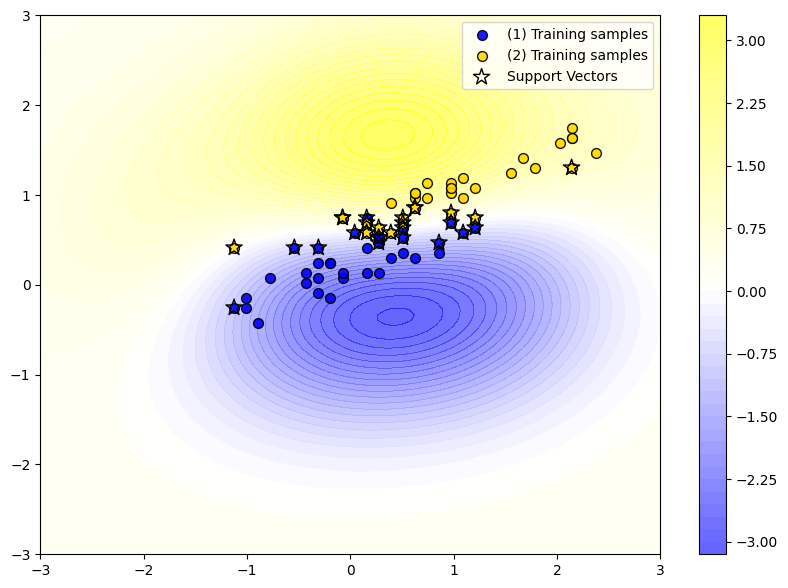

In [ ]:
# Train the soft-margin SVC
svc2 = SoftMarginSVC2(C=3,gamma=0.5)
svc2.fit(X2_train, y2_train)

# Make predictions
y2_train_pred = svc2.predict(X2_train)

# Evaluate accuracy
train_acc = np.mean(y2_train_pred == y2_train)
print("Training accuracy:", train_acc)

svc2.plot_decision(X2_train,y2_train)

## **SVM3**

In [ ]:
class SoftMarginSVC3:
    def __init__(self, C=1500, gamma=0.002):
        self.C = C           # Box constraint
        self.gamma = gamma   # RBF kernel scale
        self.X = None  # Training set X
        self.y = None  # Training set y
        self.b = 0     # Bias

    def kernel_func(self, x1, x2):
        return np.exp(-self.gamma * pairwise_distances(x1, x2, metric='sqeuclidean'))

    def fit(self, X, y):
        self.X, self.y = X, np.where(y == 0,-1,1)   # Map y \in [0,2] into [-1,1]
        n_samples = X.shape[0]

        # Create kernel (Gram) matrix
        self.K = self.kernel_func(self.X, self.X)

        # Define the objective function for the dual problem
        def objective(alpha):
            # Dual objective
            #return 0.5 * np.sum(np.outer(alpha,alpha) * np.outer(self.y,self.y) * self.K) - np.sum(alpha)
            return 0.5 * np.dot(np.dot(alpha * self.y, self.K), alpha * self.y) - np.sum(alpha)

        # Initial guess for alpha
        #initial_alpha = np.random.rand(1,n_samples)
        initial_alpha = np.zeros(n_samples)

        # Define the constraints and bounds
        cons = ({'type': 'eq', 'fun': lambda alpha: np.dot(alpha, self.y)})
        bnds = [(0, self.C) for _ in initial_alpha]

        # Minimize the objective function subject to the constraints
        res = minimize(objective, initial_alpha, constraints=cons,
                       bounds=bnds, method='SLSQP')
        print(res.message)

        # Extract the optimal alpha values
        alpha = res.x

        # Extract support vectors
        self.sv_indices = alpha > 1e-5
        self.support_vectors = self.X[self.sv_indices,:]
        self.support_labels = self.y[self.sv_indices]
        self.alpha = alpha[self.sv_indices]

        # Calculate the bias
        y_pred = self.predict_proba(self.support_vectors)
        self.b = np.mean(self.support_labels - y_pred)

    def predict(self, X):
        return np.where(self.predict_proba(X) > 0, 2, 0)

    def predict_proba(self, X):
        K = self.kernel_func(self.support_vectors, X)
        return np.dot(self.support_labels * self.alpha, K) + self.b

    def plot_decision(self, X, y):
      nx, ny = 100, 100
      xv, yv = np.meshgrid(np.linspace(-3,3,nx),
                            np.linspace(-3,3,ny))
      zv = np.zeros(xv.shape)
      for i in range(nx):
          for j in range(ny):
              zv[i,j] = self.predict_proba(np.array([xv[i,j], yv[i,j]]).reshape(1,-1))

      plt.figure(figsize=(10,7))
      # Normalize colors so that 0 will match white
      divnorm = mcolors.TwoSlopeNorm(vmin=np.min(zv), vcenter=0, vmax=np.max(zv))
      con = plt.contourf(xv, yv, zv, cmap=vwy_cmap, levels=50, alpha=0.6, norm=divnorm)
      plt.scatter(X[y == 0,0],X[y == 0,1], s=50, color='#8A2BE2', marker='o',
                  alpha=0.9, edgecolors='k', label='(0) Training samples')
      plt.scatter(X[y == 2,0],X[y == 2,1], s=50, color='#FFD700', marker='o',
                  alpha=0.9, edgecolors='k', label='(2) Training samples')
      plt.scatter(self.support_vectors[:,0],self.support_vectors[:,1], s=150,
                  marker='*', facecolors="None", edgecolors='k',label='Support Vectors')
      plt.colorbar(con)
      plt.legend()
      plt.show()

### Classifier (0v2)

Optimization terminated successfully
Training accuracy: 1.0


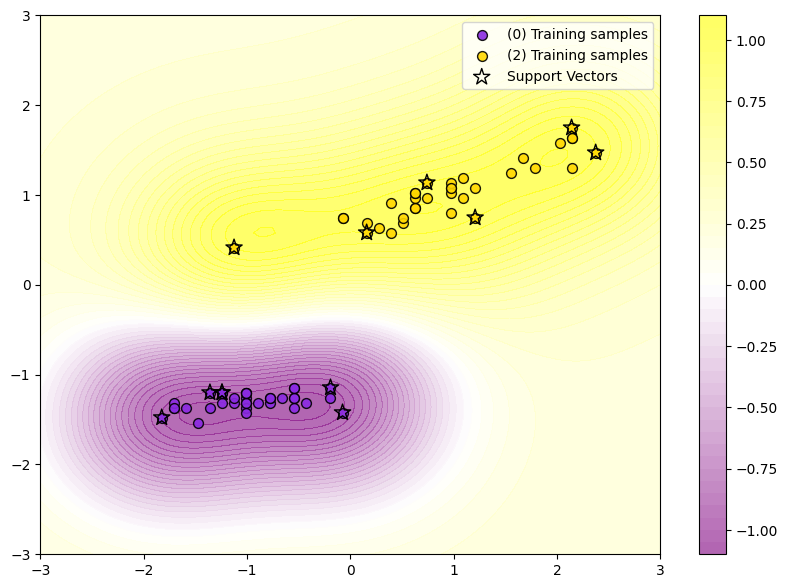

In [ ]:
# Train the soft-margin SVC
svc3 = SoftMarginSVC3(C=10,gamma=0.9)
svc3.fit(X3_train, y3_train)

# Make predictions
y3_train_pred = svc3.predict(X3_train)

# Evaluate accuracy
train_acc = np.mean(y3_train_pred == y3_train)
print("Training accuracy:", train_acc)

svc3.plot_decision(X3_train,y3_train)

## Final Classifier

In [ ]:
from collections import Counter

classifiers = [svc1,svc2,svc3]
# Make predictions for each pair of classes
predictions_train = []
predictions_test = []

for clf in classifiers:
    predictions_train.append(clf.predict(X_train_scaled))
    predictions_test.append(clf.predict(X_test_scaled))

# Combine predictions from all classifiers for training and testing datasets
combined_train_preds = np.vstack(predictions_train).T
combined_test_preds = np.vstack(predictions_test).T

# Perform majority voting for each data point
train_preds_majority = [Counter(combined_train_preds[i]).most_common(1)[0][0] for i in range(len(combined_train_preds))]
test_preds_majority = [Counter(combined_test_preds[i]).most_common(1)[0][0] for i in range(len(combined_test_preds))]

# Convert to numpy arrays
y_train_pred = np.array(train_preds_majority)
y_test_pred = np.array(test_preds_majority)

# Evaluate accuracy
train_acc = np.mean(y_train_pred == y_train)
test_acc = np.mean(y_test_pred == y_test)


# Print the majority voting predictions for the training and testing sets
print("Majority voting predictions for the training set:", y_train_pred)
print("Majority voting predictions for the testing set:", y_test_pred)
print("=="*1000)
print("Training Accuracy and Testing Accuracy for the Final Classifier")
print("Training accuracy:", train_acc)
print("Testing accuracy:", test_acc)
print("=="*1000)

Majority voting predictions for the training set: [2 2 2 0 0 0 1 2 1 2 0 1 1 1 0 0 2 1 1 2 2 1 0 0 1 1 0 1 2 2 2 2 1 2 0 0 0
 1 0 0 2 1 1 0 0 0 1 1 0 1 1 1 2 0 1 1 1 1 2 0 1 2 1 1 2 1 2 0 1 2 2 2 2 0
 2 0 0 2 1 0 0 0 0 0 1 2 2 2 0 2 0 0 1 1 1 1 0 2 2 0 2 1 0 2 2]
Majority voting predictions for the testing set: [2 2 0 0 1 0 1 2 0 1 0 2 0 1 1 2 1 1 1 0 1 2 0 1 2 2 2 2 1 2 1 0 0 1 1 2 1
 0 0 1 0 2 0 0 2]
Training Accuracy and Testing Accuracy for the Final Classifier
Training accuracy: 0.9714285714285714
Testing accuracy: 0.9777777777777777


### Scatter Plot of Predictions

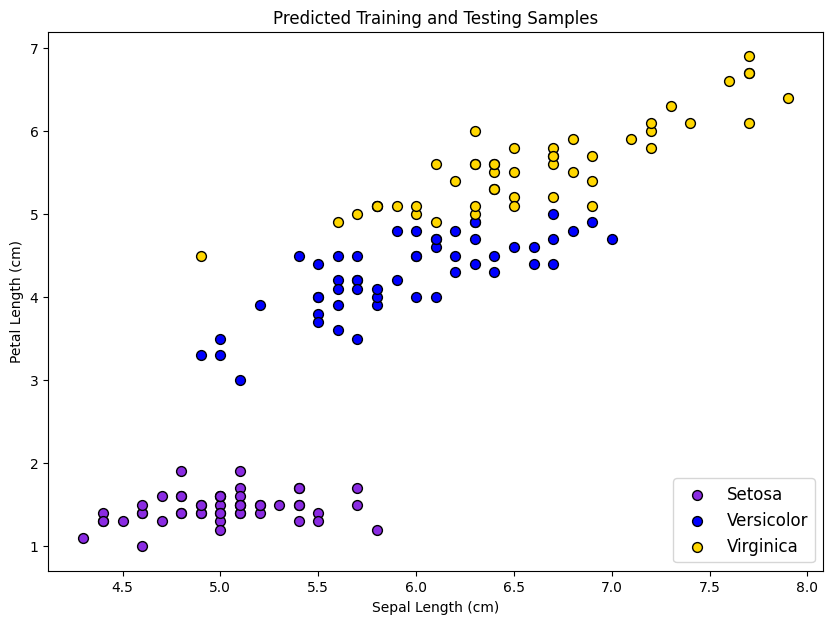

In [ ]:
# Plot scatter plot with labels for each class
plt.subplots(figsize=(10,7))


plt.scatter(X_train[:, 0][(y_train_pred == 0)], X_train[:, 1][(y_train_pred == 0)], color='#8A2BE2', s=50,edgecolors="k", label='Setosa')
plt.scatter(X_test[:, 0][(y_test_pred == 0)], X_test[:, 1][(y_test_pred == 0)], color='#8A2BE2', s=50,edgecolors="k", label='')
plt.scatter(X_train[:, 0][(y_train_pred == 1)], X_train[:, 1][(y_train_pred == 1)], color='blue',s=50, edgecolors="k", label='Versicolor')
plt.scatter(X_test[:, 0][(y_test_pred == 1)], X_test[:, 1][(y_test_pred == 1)], color='blue',s=50, edgecolors="k", label='')
plt.scatter(X_train[:, 0][(y_train_pred == 2)], X_train[:, 1][(y_train_pred == 2)], color='#FFD700',s=50, edgecolors="k", label='Virginica')
plt.scatter(X_test[:, 0][(y_test_pred == 2)], X_test[:, 1][(y_test_pred == 2)], color='#FFD700',s=50, edgecolors="k", label='')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Petal Length (cm)')
plt.legend(loc="lower right", fontsize=12)
plt.title("Predicted Training and Testing Samples")
plt.show()

### Decision Boundary Plot

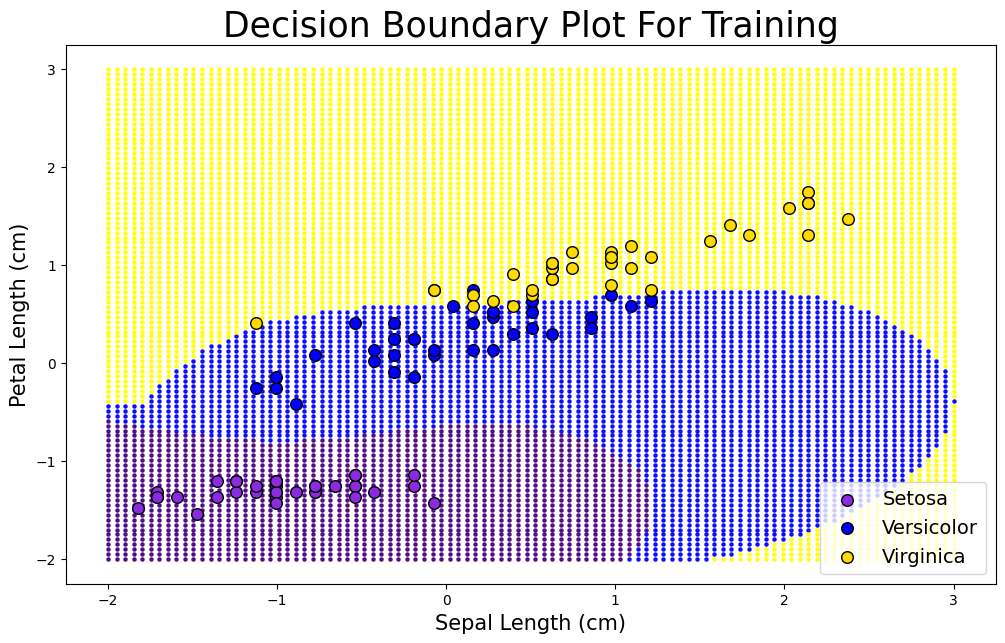

In [ ]:
from matplotlib.colors import ListedColormap

# Create a meshgrid of points
x_min, x_max = X_train_scaled[:, 0].min(), X_train_scaled[:, 0].max()
y_min, y_max = X_train_scaled[:, 1].min(), X_train_scaled[:, 1].max()
nx, ny = 100, 100
xv, yv = np.meshgrid(np.linspace(-2,3,nx), np.linspace(-2,3,ny))
# xv, yv = np.meshgrid(np.linspace(x_min,x_max,nx), np.linspace(y_min,y_max,ny))


xv, yv = xv.reshape(-1,1), yv.reshape(-1,1)
grid = np.hstack((xv,yv))

X_scaled = scalerX.fit_transform(X)

color = ['#4B0082','blue','yellow']

zv = []

for clf in classifiers:
    zv.append(clf.predict(grid))

# Combine predictions from all classifiers for training and testing datasets
zv_preds = np.vstack(zv).T

# Perform majority voting for each data point
zv_pres_vote = [Counter(zv_preds[i]).most_common(1)[0][0] for i in range(len(zv_preds))]

# Convert to numpy arrays
zv_cont= np.array(zv_pres_vote)

##Decision Boundary Plot for Training
plt.subplots(figsize=(12,7))
for i in range(3):
  plt.scatter(xv[zv_cont == i],yv[zv_cont == i], color=color[i], alpha=0.9, s=5)

plt.scatter(X_train_scaled[:, 0][(y_train == 0)], X_train_scaled[:, 1][(y_train == 0)], color='#8A2BE2', s=70,edgecolors="k", label='Setosa')
plt.scatter(X_train_scaled[:, 0][(y_train == 1)], X_train_scaled[:, 1][(y_train == 1)], color='blue',s=70, edgecolors="k", label='Versicolor')
plt.scatter(X_train_scaled[:, 0][(y_train == 2)], X_train_scaled[:, 1][(y_train == 2)], color='#FFD900',s=70, edgecolors="k", label='Virginica')
plt.xlabel('Sepal Length (cm)', fontsize=15)
plt.ylabel('Petal Length (cm)', fontsize=15)
plt.legend(loc="lower right", fontsize=14)
plt.title("Decision Boundary Plot For Training", fontsize=25)
plt.show()


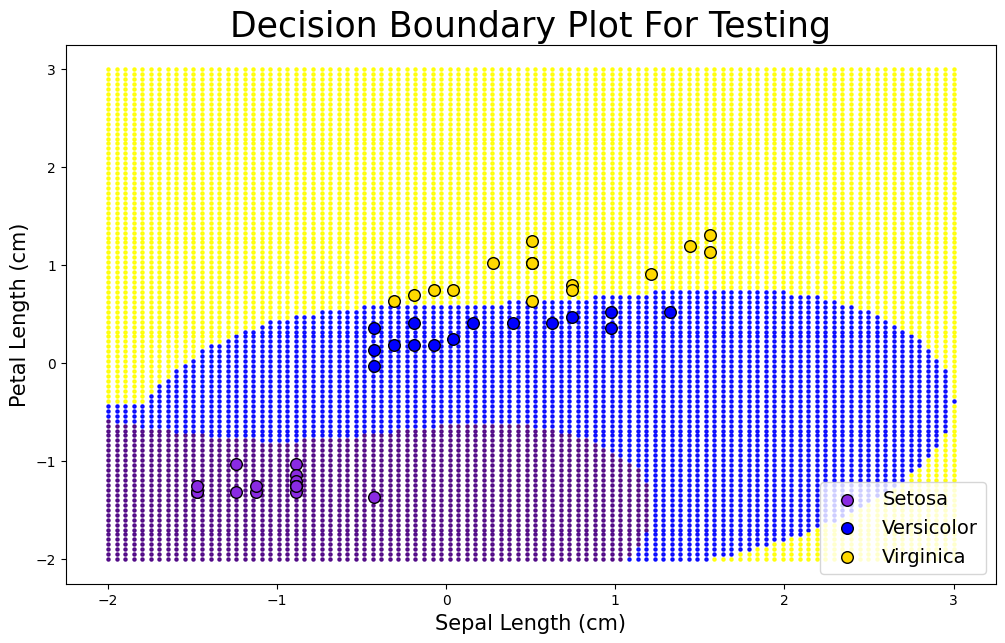

In [ ]:
##Decision Boundary Plot for Testing
plt.subplots(figsize=(12,7))
for i in range(3):
  plt.scatter(xv[zv_cont == i],yv[zv_cont == i], color=color[i], alpha=0.9, s=5)
plt.scatter(X_test_scaled[:, 0][(y_test == 0)], X_test_scaled[:, 1][(y_test == 0)], color='#8A2BE2', s=70,edgecolors="k", label='Setosa')
plt.scatter(X_test_scaled[:, 0][(y_test == 1)], X_test_scaled[:, 1][(y_test == 1)], color='blue',s=70, edgecolors="k", label='Versicolor')
plt.scatter(X_test_scaled[:, 0][(y_test == 2)], X_test_scaled[:, 1][(y_test == 2)], color='#FFD900',s=70, edgecolors="k", label='Virginica')
plt.xlabel('Sepal Length (cm)', fontsize=15)
plt.ylabel('Petal Length (cm)', fontsize=15)
plt.legend(loc="lower right", fontsize=14)
plt.title("Decision Boundary Plot For Testing", fontsize=25)
plt.show()

# Using Built in

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.inspection import DecisionBoundaryDisplay

accuracy = 0.9523809523809523
Confusion Matrix
[[35  0  0]
 [ 0 34  1]
 [ 0  4 31]]


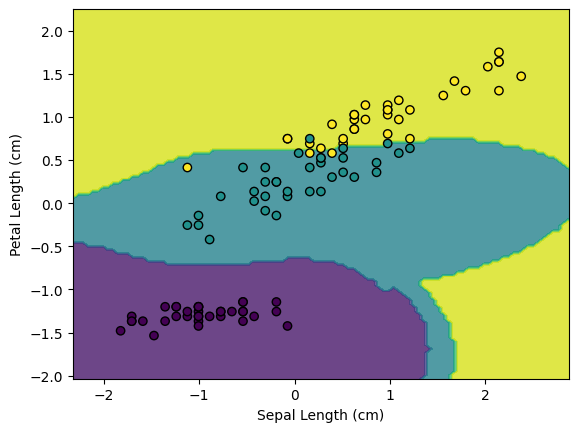

In [ ]:
svm_ovo = OneVsOneClassifier(make_pipeline(StandardScaler(), SVC())).fit(X_train_scaled,y_train)
print(f"accuracy = {svm_ovo.score(X_train_scaled, y_train)}")
print('Confusion Matrix')
print(confusion_matrix(y_train, svm_ovo.predict(X_train_scaled)))
DecisionBoundaryDisplay.from_estimator(svm_ovo, X_train_scaled, alpha=0.8, eps=0.5)
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, edgecolors="k")
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Petal Length (cm)')
plt.show()

Accuracy = 0.9555555555555556
Confusion Matrix
[[15  0  0]
 [ 0 15  0]
 [ 0  2 13]]


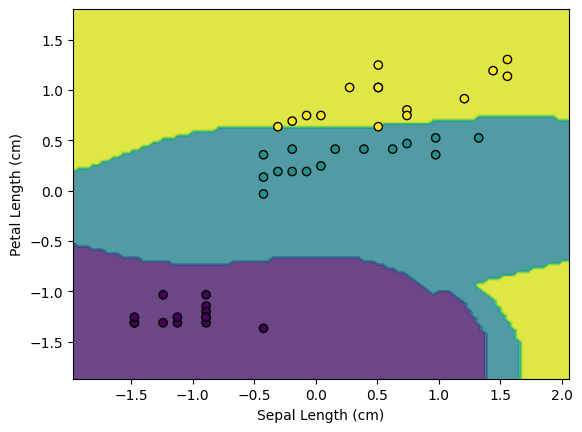

In [ ]:
# Measure accuracy with testing data
print(f"Accuracy = {svm_ovo.score(X_test_scaled, y_test)}")
print('Confusion Matrix')
print(confusion_matrix(y_test, svm_ovo.predict(X_test_scaled)))
DecisionBoundaryDisplay.from_estimator(svm_ovo, X_test_scaled, alpha=0.8, eps=0.5)
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, edgecolors="k")
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Petal Length (cm)')
plt.show()

# Comparison of SVM and Neural Networks for Multiclassifcation

For this problem we used the Dataset that is the Fisher Iris Flower Dataset from sklearn. Where we used two features "sepal length" and "petal length", and our target has 3 classes namely Setosa, Versicolor, and Virginica. From the dataset we see that Setosa versus Versicolor and Setosa versus Virginica are linearly separable and it is clear from the scatter plot that thay they don't have any overlaps so it seems that it is good for classification process. However, for Versicolor and Virginica the dataset has a some overlaps in their classes.

For each binary classifier I used Softmargin SVM and setting a value for "C" a parameter used to control how much misclassification is allowed in my dataset. The kernel that I am using as well is the Radial Basis Function (- Based on the Gaussian function (the familiar "bell curve"), it assigns higher weights to closer data points and lower weights to distant ones.) So it seems that our SVM was able to classify properly the 3 classes.

For Neural Networks, it also showed a good performance for classification it used Categorical Cross Entropy for the Objective function and the activation function used for output layer was the Softmax function.

Both methods performed well in this classification task, Neural Networks in my opinion seems to be a more straightforward approach as we directly compare the predicted output with the actual output, meanwhile for SVM we are using a Kernel Trick to map an input space of nonlinearly separable dataset to a linearly separable dataset in another feature space. The dataset is not noisy and has lesser miclassifications which somehow gives an edge already to SVM as well and there are only 3 classes which makes it easier for training as well. But for multiple classes Neural Networks might be preferred or some other more appropriate architecture of Neural Networks for classification tasks.


For this problem, I find that Support Vector Machine is easier to tune for Neural Networks. Neural Networks is harder to tune since we are trying our best to look for a good mix of hyperparameters for to acquire the function that best approximates the relationship between our features and targets. For Support Vector Machines, we converted a constrained optimization problem into an unconstrained optimization problem using its Lagrangian. So it is like we are only solving a nonlinear optimization problem with the help of some concepts form the Karush-Kuhn Tucker Theorem. In Support Vector Machines, we are trying the find the maximum margin that best separates the two classes of our data, it is primarily used for binary classification so for multiclassifcation we have schemes like one versus one and one versus all. So for SVM, since it is just solving an optimization problem as well, for me its parameters were much easier to tune, especially with the help of our Kernel the Radial Basis Function, makes it easier for this classification task.